In [1]:
import xarray as xr
import numpy as np
import netCDF4 as nc4
import pandas as pd
import dask
from matplotlib import pyplot as plt
import os
import glob
import uuid

In [2]:
versions = [xr.__version__, np.__version__, nc4.__version__, pd.__version__ ]
versions

['0.15.1', '1.18.4', '1.5.3', '1.0.3']

## Read station data from station_id 100058 from the IOOS [Environmental Sensor Map](https://sensors.ioos.us) 

Data files are contained in a subdirectory corresponding to the station_id in this repo (100058).  Resulting output file is written there at the end as well.

(SSBN7 / SUN2WAVE / SUN2W) Sunset Nearshore Wave https://stage.admin.axds.co/#!/sensors/metadata/stations/view?stationId=100058&tab=metadata

Code contributed by [Kyle Wilcox](https://github.com/kwilcox), [Jessica Austin](https://github.com/jessicaaustin), and [Micah Wengren](https://github.com/mwengren)

```
ADCP: Current speed and dir at 0,-10m (1000360, 1000356)

device_1000360.nc
	time = 1011 ;
	z = 2 ;
device_1000356.nc
	time = 1011 ;
	z = 2 ;

ADCP: Water temp at -10m (1000361)

device_1000361.nc
	time = 1011 ;
	z = 1 ;
    
Waves at surface: wave height, wave period, wind direction (1000357, 1000359, 1000358)

device_1000357.nc
	time = 1948 ;
	z = 1 ;
device_1000358.nc
	time = 338 ;
	z = 1 ;
device_1000359.nc
	time = 1948 ;
	z = 1 ;
```


In [3]:
station_id='100058'

In [4]:
# inspect all device files
# each one currently has time, z dimensions
device_files = sorted(glob.glob(station_id + '/device*.nc'))
print(device_files)
for f in device_files:
    print('\n'+f)
    d = nc4.Dataset(f)
    print(d)

['100058/device_1000356_current_dir.nc', '100058/device_1000357_wave_period.nc', '100058/device_1000358_wind_dir.nc', '100058/device_1000359_wave_height.nc', '100058/device_1000360_current_speed.nc', '100058/device_1000361_water_temp.nc']

100058/device_1000356_current_dir.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: feed_1000312_raw
    dimensions(sizes): time(1011), z(2)
    variables(dimensions): uint8 qc_agg_1000356(time,z), uint64 qc_tests_1000356(time,z), int32 time(time), float64 value_1000356(time,z), float64 z(z)
    groups: 

100058/device_1000357_wave_period.nc
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: feed_1000313_raw
    dimensions(sizes): time(1948), z(1)
    variables(dimensions): uint8 qc_agg_1000357(time,z), uint64 qc_tests_1000357(time,z), int32 time(time), float64 value_1000357(time,z), float64 z(z)
    groups: 

100058/device_1000358_wind_dir.nc
<class 'netC

#### **xarray** 

show xarray's native interpretation of the dimension coordinates for comparison on a few files (similarly, both include `time` and `z` coordinates).

In [5]:
xr.open_dataset("100058/device_1000359_wave_height.nc")

<xarray.Dataset>
Dimensions:           (time: 1948, z: 1)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
  * z                 (z) float64 0.0
Data variables:
    qc_agg_1000359    (time, z) float32 ...
    qc_tests_1000359  (time, z) float64 ...
    value_1000359     (time, z) float64 ...
Attributes:
    title:    feed_1000315_raw

In [6]:
xr.open_dataset("100058/device_1000360_current_speed.nc")

<xarray.Dataset>
Dimensions:           (time: 1011, z: 2)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2018-11-10T11:08:14
  * z                 (z) float64 -10.0 0.0
Data variables:
    qc_agg_1000360    (time, z) float32 ...
    qc_tests_1000360  (time, z) float64 ...
    value_1000360     (time, z) float64 ...
Attributes:
    title:    feed_1000316_raw

## Goal #1: Create a CF DSG Orthogonal Multidimensional Array timeSeries file with time, station dimensions

Reference: [Example H.2.1](http://cfconventions.org/cf-conventions/cf-conventions.html#_orthogonal_multidimensional_array_representation_of_time_series) in CF Guidelines Appendix H.

Use xarray open_mfdataset to combine source datasets with combine='by_coords' to end up with both `time` and `station` dimension coordinates as follows: 

```
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
```
The resulting dimensions, are a union of all dimension coordinates in the source data files: `(station: 2, time: 2621)`.


This merged dataset was created as an example of the `timeSeries - multiStation` DSF dataset structure as specified in the [IOOS Metadata Profile 1.2](https://ioos.github.io/ioos-metadata/ioos-metadata-profile-v1-2.html#platform).  It has `time` and `station` dimensions to represent the timeseries and the 'instance' dimension in [CF DSG guidelines](http://cfconventions.org/cf-conventions/cf-conventions.html#discrete-sampling-geometries).  All of the DSG 'instance' variables vary by 'station' dimension (e.g. station, latitude, longitude, z), which has a length of 2 (for multiple sensors at depth on the same physical observing platform).

* **note:** this is a similar output to Option 2 in notebook [dsg_timeseries_micah_testing.ipynb](https://github.com/mwengren/notebooks-dev/blob/master/netcdf_cf/dsg_timeseries_micah_testing.ipynb)



In [7]:
%%time
# combine source files:
timeseries_dsg_oma = xr.open_mfdataset(device_files, combine='by_coords', parallel=True)
timeseries_dsg_oma = timeseries_dsg_oma.rename_dims({"z": "station"})
#timeseries_dsg_oma = timeseries_dsg_oma.reset_coords()
timeseries_dsg_oma['station']=(['station'], [1,2])
timeseries_dsg_oma['latitude']=(['station'], [33.8444]*2)
timeseries_dsg_oma['longitude']=(['station'], [-78.4839]*2)
timeseries_dsg_oma = timeseries_dsg_oma.set_coords({"latitude", "longitude"})
timeseries_dsg_oma

CPU times: user 209 ms, sys: 27.8 ms, total: 236 ms
Wall time: 230 ms


<xarray.Dataset>
Dimensions:           (station: 2, time: 2621)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Data variables:
    qc_agg_1000356    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000358  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000358     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000359    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000359  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000359     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000360    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000360  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000360     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000361    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000361  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000361     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
Attributes:
    title:    feed_1000312_raw

In [8]:
print(timeseries_dsg_oma)

<xarray.Dataset>
Dimensions:           (station: 2, time: 2621)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Data variables:
    qc_agg_1000356    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (time, station) float32 dask.

## Goal #2: Create an equivalent CF DSG Incomplete Multidimensional Array DSG dataset

Reference: [Example H.2.2](http://cfconventions.org/cf-conventions/cf-conventions.html#_incomplete_multidimensional_array_representation_of_time_series) in CF Guidelines Appendix H.

Attempt to use `concat_dim` to prevent xarray from merging the `time` dimensions from source files in open_mfdataset, to end up with coordinates like the following (changing the `time` dimension to `obs` to match CF DSG Example H.2.2).  Note the different dimensionality in the `time` coordinate:

```
Coordinates:
    time              (obs, station) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
```


In the code in the CF DSG Orthogonal Multidimensional Array cell above this, xarray performs a merge on all `time` coordinate values in the source files and the result is a coordinate variable `time (time) datetime64[ns]` that contains the union of all individual time steps from the sources.  Resulting dimensions: `time: 2621, station: 2`.

Here, the goal is to convert time to an xarray ['Non-Dimension Coordinate'](http://xarray.pydata.org/en/stable/data-structures.html#coordinates), with time varying additionally by the `station` dimension:  `time (obs, station) datetime64[ns]`.   Because the longest `time` dimension in the source files is 1948, we'd expect slightly more efficient dimensionality in the resulting output file of: `obs: 1948, station: 2`.

I'm unsuccessful thus far in figuruing out how to do this.  All variations of `concat_dims=[None, 'z']` or the reverse don't seem to change the underlying combine/merge that happens and the same dimensionality results (only with dimension name of `obs` rather than `time`).  

Clearly I don't understand how these functions are meant to work!  Also, xarray documentation on some of the open_mfdataset, combine_by_coords, combine_nested, concat, merge, etc is lacking IMO to be usable for xarray novices like myself.  Some good use case examples such as this one would help, if this is actually possible to do in xarray.

Commented code left in place to show various options I tried:

In [9]:
%%time
# combine source files:
timeseries_dsg_ima = xr.open_mfdataset(device_files, combine='by_coords', concat_dim=[None, "z"], parallel=True)
#timeseries_dsg_ima = xr.open_mfdataset(device_files, combine='by_coords', concat_dim=["z", None], parallel=True)
#timeseries_dsg_ima = xr.open_mfdataset(device_files, combine='by_coords', concat_dim=["z", None], coords=["minimal"], parallel=True)

#timeseries_dsg_ima = xr.open_mfdataset(device_files, combine='nested', concat_dim=["z"], parallel=True)

timeseries_dsg_ima = timeseries_dsg_ima.rename_dims({"time": "obs"})
timeseries_dsg_ima = timeseries_dsg_ima.rename_dims({"z": "station"})
#timeseries_dsg_ima = timeseries_dsg_ima.reset_coords()
timeseries_dsg_ima['station']=(['station'], [1,2])
timeseries_dsg_ima['latitude']=(['station'], [33.8444]*2)
timeseries_dsg_ima['longitude']=(['station'], [-78.4839]*2)
timeseries_dsg_ima = timeseries_dsg_ima.set_coords({"latitude", "longitude"})
timeseries_dsg_ima

CPU times: user 178 ms, sys: 11.8 ms, total: 190 ms
Wall time: 183 ms


<xarray.Dataset>
Dimensions:           (obs: 2621, station: 2)
Coordinates:
    time              (obs) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Dimensions without coordinates: obs
Data variables:
    qc_agg_1000356    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000358  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000358     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000359    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000359  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000359     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000360    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000360  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000360     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000361    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000361  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000361     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
Attributes:
    title:    feed_1000312_raw

In [10]:
print(timeseries_dsg_ima)

<xarray.Dataset>
Dimensions:           (obs: 2621, station: 2)
Coordinates:
    time              (obs) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Dimensions without coordinates: obs
Data variables:
    qc_agg_1000356    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (obs, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (obs, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (

#### Add Attribution:

Add some minimal attribution for partial [IOOS Metadata Profile 1.2](https://ioos.github.io/ioos-metadata/ioos-metadata-profile-v1-2.html) compliance:

In [11]:
timeseries_dsg_oma['station'].attrs['cf_role'] = 'timeseries_id'
timeseries_dsg_oma.attrs['cdm_data_type'] = 'TimeSeries'
timeseries_dsg_oma.attrs['cdm_timeseries_variables'] = 'station,longitude,latitude,z'
timeseries_dsg_oma.attrs['title'] = 'DSG TimeSeries'

timeseries_dsg_oma['value_1000356'].attrs['standard_name'] = 'sea_water_velocity_to_direction'
timeseries_dsg_oma['value_1000357'].attrs['standard_name'] = 'sea_surface_wave_significant_period'
timeseries_dsg_oma['value_1000358'].attrs['standard_name'] = 'wind_from_direction'
timeseries_dsg_oma['value_1000359'].attrs['standard_name'] = 'sea_surface_wave_significant_height'
timeseries_dsg_oma['value_1000360'].attrs['standard_name'] = 'sea_water_speed'
timeseries_dsg_oma['value_1000361'].attrs['standard_name'] = 'sea_water_temperature'

timeseries_dsg_oma['value_1000356'].attrs['platform'] = 'station'
timeseries_dsg_oma['value_1000357'].attrs['platform'] = 'station'
timeseries_dsg_oma['value_1000358'].attrs['platform'] = 'station'
timeseries_dsg_oma['value_1000359'].attrs['platform'] = 'station'
timeseries_dsg_oma['value_1000360'].attrs['platform'] = 'station'
timeseries_dsg_oma['value_1000361'].attrs['platform'] = 'station'

timeseries_dsg_oma['station'].attrs['cf_role'] = 'timeseries_id'
timeseries_dsg_oma['value_1000361']
timeseries_dsg_oma

<xarray.Dataset>
Dimensions:           (station: 2, time: 2621)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Data variables:
    qc_agg_1000356    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000358  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000358     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000359    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000359  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000359     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000360    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000360  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000360     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000361    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000361  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000361     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
Attributes:
    title:                     DSG TimeSeries
    cdm_data_type:             TimeSeries
    cdm_timeseries_variables:  station,longitude,latitude,z

## Examine Results:

**Waves (data for z=0 only):**

Wave measurements are taken only at the surface, so the z=-10 slice (station=1) will have no data

In [12]:
# z=-10|station=1: this is an empty slice:
#timeseries_dsg_oma.value_1000359.loc['2018-06-30T08:00:00':'2018-06-30T12:00:00',1].compute()

# use xarray .sel selections instead:
#timeseries_dsg_oma.value_1000359.sel(station=1, time=slice('2018-06-30T08:00:00','2018-06-30T12:00:00'))
timeseries_dsg_oma.value_1000359.sel(station=1, time=slice('2018-06-30T08:00:00','2018-06-30T12:00:00')).compute()

<xarray.DataArray 'value_1000359' (time: 13)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
  * time       (time) datetime64[ns] 2018-06-30T08:00:00 ... 2018-06-30T12:00:00
    z          float64 -10.0
    station    int64 1
    latitude   float64 33.84
    longitude  float64 -78.48
Attributes:
    standard_name:  sea_surface_wave_significant_height
    platform:       station

The z=0 slice (station=2) will have wave obs values:

In [13]:
# z=0|station=2: this has data:
#timeseries_dsg_oma.value_1000359.loc['2018-06-30T08:00:00':'2018-06-30T12:00:00',2].compute()
timeseries_dsg_oma.value_1000359.sel(station=2, time=slice('2018-06-30T08:00:00','2018-06-30T12:00:00')).compute()

<xarray.DataArray 'value_1000359' (time: 13)>
array([0.39,  nan,  nan, 0.4 ,  nan,  nan, 0.32,  nan,  nan, 0.32,  nan,
        nan, 0.35])
Coordinates:
  * time       (time) datetime64[ns] 2018-06-30T08:00:00 ... 2018-06-30T12:00:00
    z          float64 0.0
    station    int64 2
    latitude   float64 33.84
    longitude  float64 -78.48
Attributes:
    standard_name:  sea_surface_wave_significant_height
    platform:       station

**Current Speed (data for both z values):**

The z=-10 slice (station=1) will have current speed measurements:

In [14]:
# z=-10|station=1:
#timeseries_dsg_oma.value_1000360.loc['2018-06-30T08:00:00':'2018-06-30T12:00:00',1].compute()
timeseries_dsg_oma.value_1000360.sel(station=1, time=slice('2018-06-30T08:00:00','2018-06-30T12:00:00')).compute()

<xarray.DataArray 'value_1000360' (time: 13)>
array([0.063, 0.073, 0.008, 0.033, 0.077, 0.083, 0.048, 0.042, 0.033,
       0.019, 0.044, 0.036, 0.07 ])
Coordinates:
  * time       (time) datetime64[ns] 2018-06-30T08:00:00 ... 2018-06-30T12:00:00
    z          float64 -10.0
    station    int64 1
    latitude   float64 33.84
    longitude  float64 -78.48
Attributes:
    standard_name:  sea_water_speed
    platform:       station

The z=0 slice (station=2) will also have current speed measurements:

In [15]:
# z=0|station=2:
#timeseries_dsg_oma.value_1000360.loc['2018-06-30T08:00:00':'2018-06-30T12:00:00',2].compute()
timeseries_dsg_oma.value_1000360.sel(station=2, time=slice('2018-06-30T08:00:00','2018-06-30T12:00:00')).compute()

<xarray.DataArray 'value_1000360' (time: 13)>
array([0.042, 0.126, 0.079, 0.127, 0.108, 0.141, 0.088, 0.116, 0.074,
       0.064, 0.095, 0.073, 0.122])
Coordinates:
  * time       (time) datetime64[ns] 2018-06-30T08:00:00 ... 2018-06-30T12:00:00
    z          float64 0.0
    station    int64 2
    latitude   float64 33.84
    longitude  float64 -78.48
Attributes:
    standard_name:  sea_water_speed
    platform:       station

## Write out netCDF output file:

This output file will work for ERDDAP testing for a basic **timeSeries - multiStation** dataset

In [16]:
%%time

encoding={
    'latitude': {'dtype': 'float32', '_FillValue': -9999.9},
    'longitude': {'dtype': 'float32', '_FillValue': -9999.9},
    'z': {'dtype': 'float32', '_FillValue': -9999.9},
    'time': {'dtype': 'int32', '_FillValue': -9999},
    'station': {'dtype': 'int16', '_FillValue': -9999}
}

# write to single netcdf
#timeseries_filename = f"{station_id}/station_{station_id}_timeseries_{uuid.uuid4().hex}.nc"
timeseries_filename = f"{station_id}/station_{station_id}_timeseries_multistation.nc"
print(timeseries_filename)
timeseries_dsg_oma.to_netcdf(timeseries_filename, encoding=encoding)

100058/station_100058_timeseries_multistation.nc
CPU times: user 177 ms, sys: 12.8 ms, total: 190 ms
Wall time: 189 ms


## To Do:

Because each variable isn't measured at each depth (or 'station') - wind, waves, water temp, etc - there are large gaps in the resulting netCDF file for empty timeSeries.  This is probably unavoidable, unless perhaps using one of the ragged array DSG types: http://cfconventions.org/cf-conventions/cf-conventions.html#representations-features.


## Plotting:

This is just for visualizing output/debugging.

In [17]:
timeseries_dsg_oma

<xarray.Dataset>
Dimensions:           (station: 2, time: 2621)
Coordinates:
  * time              (time) datetime64[ns] 2018-06-30T08:00:00 ... 2020-02-18T15:52:00
    z                 (station) float64 -10.0 0.0
  * station           (station) int64 1 2
    latitude          (station) float64 33.84 33.84
    longitude         (station) float64 -78.48 -78.48
Data variables:
    qc_agg_1000356    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000356  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000356     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000357    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000357  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000357     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000358    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000358  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000358     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000359    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000359  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000359     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000360    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000360  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000360     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_agg_1000361    (time, station) float32 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    qc_tests_1000361  (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
    value_1000361     (time, station) float64 dask.array<chunksize=(2621, 2), meta=np.ndarray>
Attributes:
    title:                     DSG TimeSeries
    cdm_data_type:             TimeSeries
    cdm_timeseries_variables:  station,longitude,latitude,z

#### Plot wave height (value_100359) at surface:

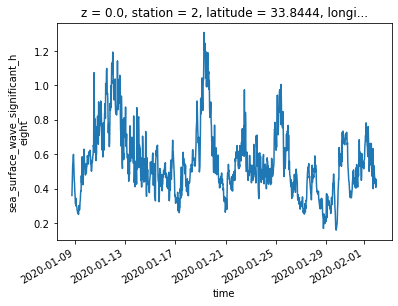

In [18]:
timeseries_dsg_oma.sel(time=slice("2020-01-01", "2020-02-01"),station=2).value_1000359.plot.line(x="time");
#timeseries_dsg_oma.sel(time=slice("2019-01-01", None),station=2).value_1000360.plot.line(x="time");

#### Plot current speed (value_100360) at depth 0, 10:

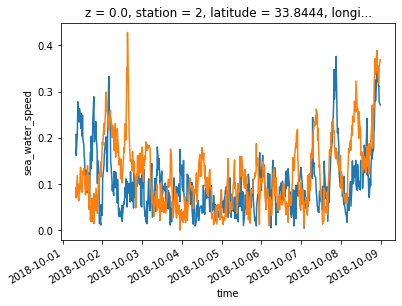

In [19]:
timeseries_dsg_oma.sel(time=slice("2018-10-01", "2018-10-8"),station=1).value_1000360.plot.line(x="time");
timeseries_dsg_oma.sel(time=slice("2018-10-01", "2018-10-8"),station=2).value_1000360.plot.line(x="time");